# Train Basic Communications

Let us train a one-way communication system from scratch. First, let's import the necessary components.

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import torch
from IPython.display import Image
from torch import nn
from tqdm import tqdm

from torchradio import Receiver, Transmitter
from torchradio.algorithm.example import DenseRadio
from torchradio.env.null import RandomAWGNEnvironment

We will use a predefined trainable `DenseRadio` from the `torchradio.algorithm.example` module. As its name suggests, a `DenseRadio` uses so-called ["dense" layers](https://en.wikipedia.org/wiki/Layer_(deep_learning)) to encode and decode messages. The `DenseRadio` is not especially configurable, but is good enough for the purposes of this notebook. Feel free to study the `DenseRadio` implementation to help you design your own trainable radios.

We instantiate the radio and define a similar environment to that described in [train_detector.ipynb](./train_detector.ipynb).

In [2]:
dense_radio = DenseRadio(8, 2)
transmitters = {"dense_tx": Transmitter(dense_radio.tx)}
receivers = {"dense_rx": Receiver(dense_radio.rx)}
env = RandomAWGNEnvironment(0, 1.0)
env.place(transmitters, receivers)

Next, define a training loop that penalises bit errors.

In [3]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(dense_radio.parameters(), lr=5e-4)


def _train(
    n_timesteps: int,
    batch_size: int,
) -> dict[str, float]:
    optimizer.zero_grad()

    device_logs = env.simulate(n_timesteps, batch_size)

    tx_bits = device_logs.tx["dense_tx"].metadata["bits"]
    rx_outputs = device_logs.rx["dense_rx"]["bit_probabilities"]
    rx_bits = device_logs.rx["dense_rx"]["bits"]

    # compute loss, gradient and update parameters
    loss = loss_fn(rx_outputs, tx_bits.float())
    loss.backward()
    optimizer.step()

    return {
        "loss": loss.detach().numpy(),
        "accuracy": np.mean((tx_bits == rx_bits).numpy()),
    }

We can now call `_train` multiple times to train our radio.

In [4]:
# track metrics over time
losses = []
bit_error_rates = []

n_iterations = 2000
batch_size = 10
n_timesteps = 64

for _ in tqdm(range(n_iterations)):
    train_logs = _train(n_timesteps, batch_size)
    losses.append(train_logs["loss"])
    bit_error_rates.append(1 - train_logs["accuracy"])

100%|██████████| 2000/2000 [00:01<00:00, 1045.30it/s]


We can plot the loss per iteration.

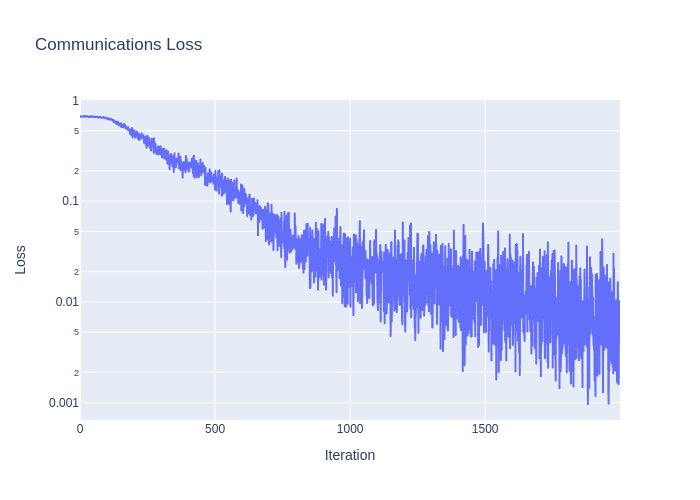

In [5]:
fig = px.line(
    pd.DataFrame({"loss": losses, "iteration": list(range(len(losses)))}),
    x="iteration",
    y="loss",
    log_y=True,
    title="Communications Loss",
    labels={"iteration": "Iteration", "loss": "Loss"},
)
Image(fig.to_image(format="png"))

We can also plot the bit-error-rate per iteration.

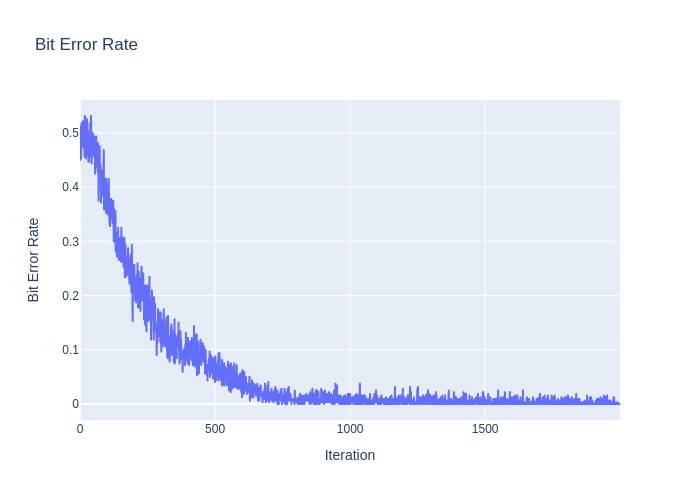

In [6]:
fig = px.line(
    pd.DataFrame(
        {
            "bit_error_rates": bit_error_rates,
            "iteration": list(range(len(bit_error_rates))),
        },
    ),
    x="iteration",
    y="bit_error_rates",
    log_y=False,
    title="Bit Error Rate",
    labels={"iteration": "Iteration", "bit_error_rates": "Bit Error Rate"},
)
Image(fig.to_image(format="png"))